In [1]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from google.colab import files
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

#데이터 불러오기

In [2]:
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv')
df.head()

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [3]:
df = df.drop('Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


#결측치 처리

In [4]:
df.isna().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

##Year 결측치 처리

In [5]:
platform_year_median = df.groupby(['Platform']).Year.median()
platform_year = dict(platform_year_median)
platform_year

{'2600': 1982.0,
 '3DO': 1995.0,
 '3DS': 2013.0,
 'DC': 2000.0,
 'DS': 2008.0,
 'GB': 1997.0,
 'GBA': 2003.0,
 'GC': 2003.0,
 'GEN': 1993.0,
 'GG': 1992.0,
 'N64': 1999.0,
 'NES': 1986.5,
 'NG': 1994.5,
 'PC': 2009.0,
 'PCFX': 1996.0,
 'PS': 1998.0,
 'PS2': 2004.0,
 'PS3': 2011.0,
 'PS4': 2015.0,
 'PSP': 2009.0,
 'PSV': 2014.0,
 'SAT': 1996.0,
 'SCD': 1994.0,
 'SNES': 1994.0,
 'TG16': 1995.0,
 'WS': 2000.0,
 'Wii': 2009.0,
 'WiiU': 2013.0,
 'X360': 2010.0,
 'XB': 2004.0,
 'XOne': 2015.0}

In [6]:
for i in df.index:
  platform = df.loc[i, 'Platform']
  year = df.loc[i, 'Year']
  if np.isnan(year):
    df.loc[i, 'Year'] = platform_year[platform]

In [7]:
df.isna().sum()

Name            0
Platform        0
Year            0
Genre          50
Publisher      58
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
dtype: int64

##Genre 결측치 처리

In [8]:
df_genre_nan = df[(df['Genre'].isna())]
genre_nan_name = df_genre_nan['Name'].unique() # 장르 컬럼이 nan인 게임 이름 목록

# 동명 게임 중에 Genre 정보가 있는 df (활용 가능)
condition = ((df['Name'].isin(genre_nan_name)) & (df['Genre'].isna() == False))
can_fill_genre_df = df[condition]

ng_df = can_fill_genre_df[['Name', 'Genre']]

game_genre = dict() # key : 게임 이름, value : 게임 장르
for i in ng_df.index:
  name = ng_df.loc[i, 'Name']
  genre = ng_df.loc[i, 'Genre']
  game_genre[name] = genre

In [9]:
# Genre 결측치 채우기 (1차)
for i in df.index:
  name = df.loc[i, 'Name']
  genre = df.loc[i, 'Genre']
  if (name in game_genre) & (genre is np.nan):
    df.loc[i, 'Genre'] = game_genre[name]

In [10]:
df.isna().sum()

Name            0
Platform        0
Year            0
Genre          30
Publisher      58
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
dtype: int64

In [11]:
# 남은 Genre 결측치 게임 이름 목록
df[(df['Genre'].isna())]['Name'].unique()

array(['Ape Escape: On the Loose', 'SingStar Singalong With Disney',
       'Pokemon X/Pokemon Y', 'NASCAR Racing',
       'Jurassic Park III: Island Attack', 'The Godfather: Dons Edition',
       'Princess Saver! Eternal Love for My Lady',
       'Brain Quest: Grades 5 & 6', 'Wii Party', 'Astonishia Story',
       'Chrono Cross', 'Medabots: Metabee', 'UFO: Trilogy',
       'Largo Winch .// Commando Sar', 'Ukiyo no Shishi',
       'Myth Makers: Orbs of Doom', 'Final Fantasy XII',
       'Bakemonogatari Portable', 'Puppy Palace', 'Yakuza 3', 'F-Zero X',
       'Onimusha: Warlords', 'Virtual Chess 64',
       'PQ2: Practical Intelligence Quotient', 'Urban Chaos',
       'Treasure Report: Kikai Jikake no Isan',
       'Myth Makers: Super Kart GP', 'WarioWare, Inc.: Mega Party Game$',
       'Bloodborne', 'Brain Boost: Beta Wave'], dtype=object)

In [12]:
# 30개 게임 장르 구글링해서 채우기 game_genre[name] = genre
game_genre['Ape Escape: On the Loose'] = 'Platform'
game_genre['SingStar Singalong With Disney'] = 'Misc'
game_genre['Pokemon X/Pokemon Y'] = 'Role-Playing'
game_genre['NASCAR Racing'] = 'Racing'
game_genre['Jurassic Park III: Island Attack'] = 'Adventure'
game_genre['The Godfather: Dons Edition'] = 'Action'
game_genre['Princess Saver! Eternal Love for My Lady'] = 'Adventure'
game_genre['Brain Quest: Grades 5 & 6'] = 'Misc'
game_genre['Wii Party'] = 'Misc'
game_genre['Astonishia Story'] = 'Role-Playing'
game_genre['Chrono Cross'] = 'Role-Playing'
game_genre['Medabots: Metabee'] = 'Role-Playing'
game_genre['UFO: Trilogy'] = 'Strategy'
game_genre['Largo Winch .// Commando Sar'] = 'Adventure'
game_genre['Ukiyo no Shishi'] = 'Action'
game_genre['Myth Makers: Orbs of Doom'] = 'Puzzle'
game_genre['Final Fantasy XII'] = 'Role-Playing'
game_genre['Bakemonogatari Portable'] = 'Action'
game_genre['Puppy Palace'] = 'Simulation'
game_genre['Yakuza 3'] = 'Action'
game_genre['F-Zero X'] = 'Racing'
game_genre['Onimusha: Warlords'] = 'Action'
game_genre['Virtual Chess 64'] = 'Misc'
game_genre['PQ2: Practical Intelligence Quotient'] = 'Puzzle'
game_genre['Urban Chaos'] = 'Shooter'
game_genre['Treasure Report: Kikai Jikake no Isan'] = 'Adventure'
game_genre['Myth Makers: Super Kart GP'] = 'Racing'
game_genre['WarioWare, Inc.: Mega Party Game$'] = 'Puzzle'
game_genre['Bloodborne'] = 'Action'
game_genre['Brain Boost: Beta Wave'] = 'Puzzle'

In [13]:
# Genre 결측치 채우기 (2차)
for i in df.index:
  name = df.loc[i, 'Name']
  genre = df.loc[i, 'Genre']
  if (name in game_genre) & (genre is np.nan):
    df.loc[i, 'Genre'] = game_genre[name]

In [14]:
df.isna().sum()

Name            0
Platform        0
Year            0
Genre           0
Publisher      58
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
dtype: int64

##Publisher 결측치 처리

In [15]:
df_publisher_nan = df[(df['Publisher'].isna())]
df_publisher_nan_name = df_publisher_nan['Name'].unique() # 퍼블리셔 컬럼이 nan인 게임 이름 목록

# 동명 게임 중에 Publisher 정보가 있는 df (활용 가능)
condition = ((df['Name'].isin(df_publisher_nan_name)) & (df['Publisher'].isna() == False))
can_fill_publisher_df = df[condition]

np_df = can_fill_publisher_df[['Name', 'Publisher']]

game_publisher = dict()
for i in np_df.index:
  name = np_df.loc[i, 'Name']
  publisher = np_df.loc[i, 'Publisher']
  game_publisher[name] = publisher

In [16]:
# Publisher 결측치 채우기
for i in df.index:
  name = df.loc[i, 'Name']
  publisher = df.loc[i, 'Publisher']
  if (name in game_publisher) & (publisher is np.nan):
    df.loc[i, 'Publisher'] = game_publisher[name]

In [17]:
df.isna().sum()

Name            0
Platform        0
Year            0
Genre           0
Publisher      51
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
dtype: int64

##나머지 결측치 DROP

In [18]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16547 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16547 non-null  object 
 1   Platform     16547 non-null  object 
 2   Year         16547 non-null  float64
 3   Genre        16547 non-null  object 
 4   Publisher    16547 non-null  object 
 5   NA_Sales     16547 non-null  object 
 6   EU_Sales     16547 non-null  object 
 7   JP_Sales     16547 non-null  object 
 8   Other_Sales  16547 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.3+ MB


#EDA

##Year 데이터 전처리

In [19]:
print(sorted(df['Year'].unique()))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 86.0, 94.0, 95.0, 96.0, 97.0, 98.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2020.0]


In [20]:
# 0~9 drop
df.drop(df[df['Year'] < 10].index, inplace=True)

In [21]:
# 10~16 -> 20XX
# 86.0, 94.0, 95.0, 96.0, 97.0, 98.0, -> 19XX
def preprocess_year(data):
  num = [86, 94, 95, 96, 97, 98]
  if data < 18:
    return (data+2000)
  elif data in num:
    return (data+1900)
  return data

df['Year'] = df['Year'].apply(preprocess_year)
print(sorted(df['Year'].unique()))

[1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2020.0]


In [22]:
df[(df['Year'] == 2020.0)]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
6906,Imagine: Makeup Artist,DS,2020.0,Simulation,Ubisoft,0.27,0K,0,0.02


In [23]:
# Imagine: Makeup Artist 게임 Year 수정
df.loc[6906, 'Year'] = 2009.0
df[(df['Name'] == 'Imagine: Makeup Artist')]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
6906,Imagine: Makeup Artist,DS,2009.0,Simulation,Ubisoft,0.27,0K,0,0.02


In [24]:
# toInt
def toInt(data):
  return int(data)

df['Year'] = df['Year'].apply(toInt)
print(sorted(df['Year'].unique()))

[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]


##Sales 데이터 전처리

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16494 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         16494 non-null  object
 1   Platform     16494 non-null  object
 2   Year         16494 non-null  int64 
 3   Genre        16494 non-null  object
 4   Publisher    16494 non-null  object
 5   NA_Sales     16494 non-null  object
 6   EU_Sales     16494 non-null  object
 7   JP_Sales     16494 non-null  object
 8   Other_Sales  16494 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.9+ MB


In [26]:
# *_Sales (object -> 단위 스트링 제거 -> float)
def toNumeric(data):
  # K, M을 포함하지 않으면 to_numeric
  # M을 포함하면 M 제거 후 to_numeric
  # K를 포함하면 K 제거 후 to_numeric -> M 단위로 변환
  if 'M' in data or 'm' in data:
    data = data.replace('M', '')
    data = data.replace('m', '')
    data = pd.to_numeric(data)
  elif 'K' in data or 'k' in data:
    data = data.replace('K', '')
    data = data.replace('k', '')
    data = pd.to_numeric(data)
    data /= 1000
  else:
    data = pd.to_numeric(data)
  return data

In [27]:
df['NA_Sales'] = df['NA_Sales'].apply(toNumeric)
df['EU_Sales'] = df['EU_Sales'].apply(toNumeric)
df['JP_Sales'] = df['JP_Sales'].apply(toNumeric)
df['Other_Sales'] = df['Other_Sales'].apply(toNumeric)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16494 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16494 non-null  object 
 1   Platform     16494 non-null  object 
 2   Year         16494 non-null  int64  
 3   Genre        16494 non-null  object 
 4   Publisher    16494 non-null  object 
 5   NA_Sales     16494 non-null  float64
 6   EU_Sales     16494 non-null  float64
 7   JP_Sales     16494 non-null  float64
 8   Other_Sales  16494 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 1.9+ MB


In [29]:
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04
...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0.00,0.01
16594,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0.00,0.00,0.00
16595,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16596,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03


#Analysis

##연도별 게임의 트렌드는?

In [30]:
df[(df['Year'] == 2017)]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
5310,Brothers Conflict: Precious Baby,PSV,2017,Action,Idea Factory,0.0,0.0,0.01,0.0
10107,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017,Role-Playing,Sega,0.0,0.0,0.03,0.0
15233,Phantasy Star Online 2 Episode 4: Deluxe Package,PSV,2017,Role-Playing,Sega,0.0,0.0,0.01,0.0




> 1980~2016년 사이에 출시된 게임 장르의 변화를 알아봅니다.



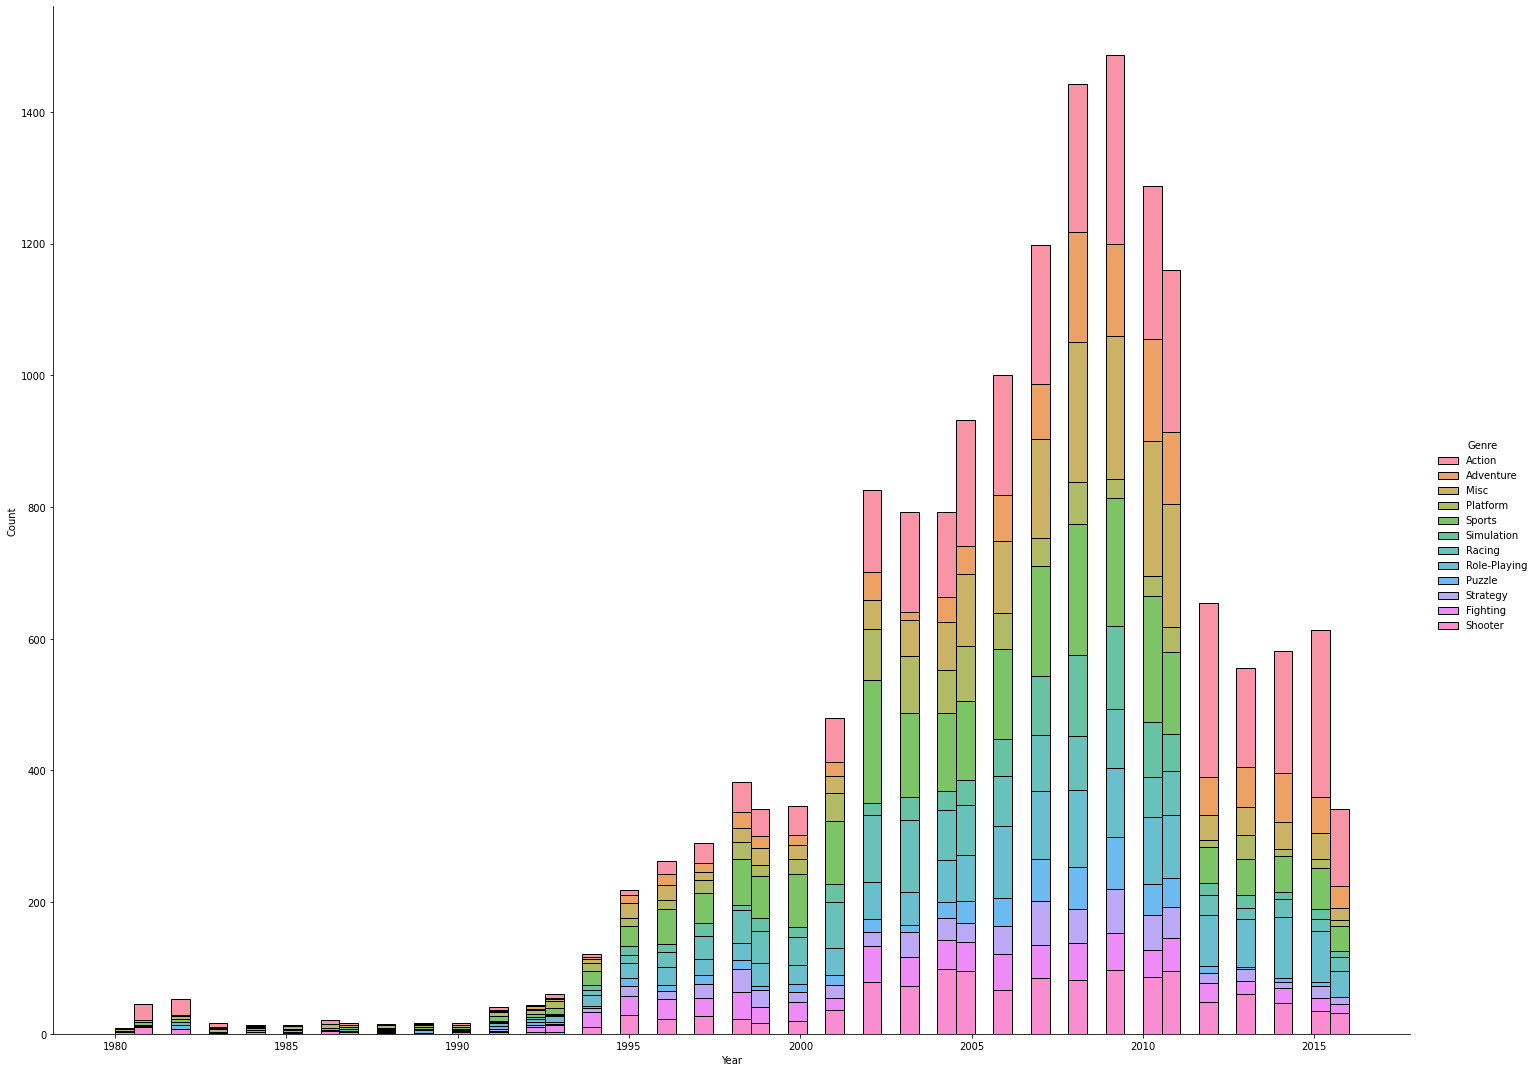

In [31]:
df1 = df[(df['Year'] != 2017)]
sns.displot(df1, x='Year', hue='Genre', multiple='stack', height=15, aspect=20/15);

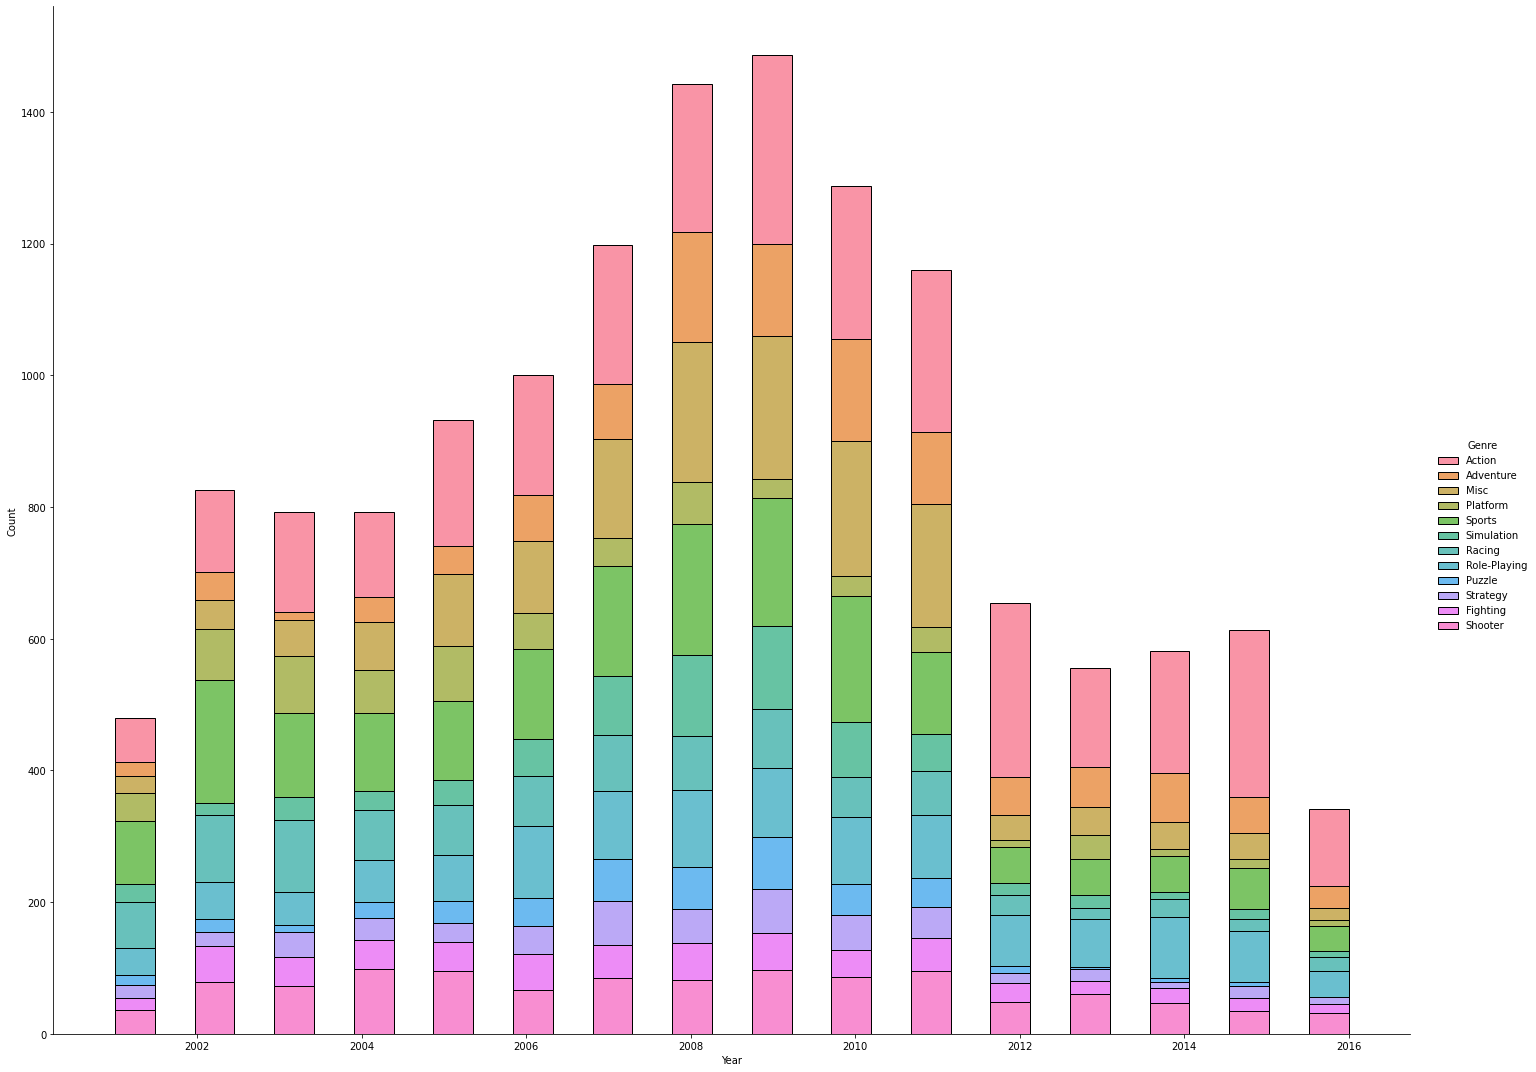

In [32]:
df2 = df[(df['Year'] > 2000) & (df['Year'] != 2017)]
sns.displot(df2, x='Year', hue='Genre', multiple='stack', height=15, aspect=20/15);



> 2000년도 이후부터는 Action, Adventure, Miscellaneous, Sports 장르가, 2012년을 기점으로는 Action 장르가
가장 많이 출시되고 있음을 알 수 있습니다.





> 장르 이외에 게임 플랫폼은 어떻게 변화했을지 알아봅니다.



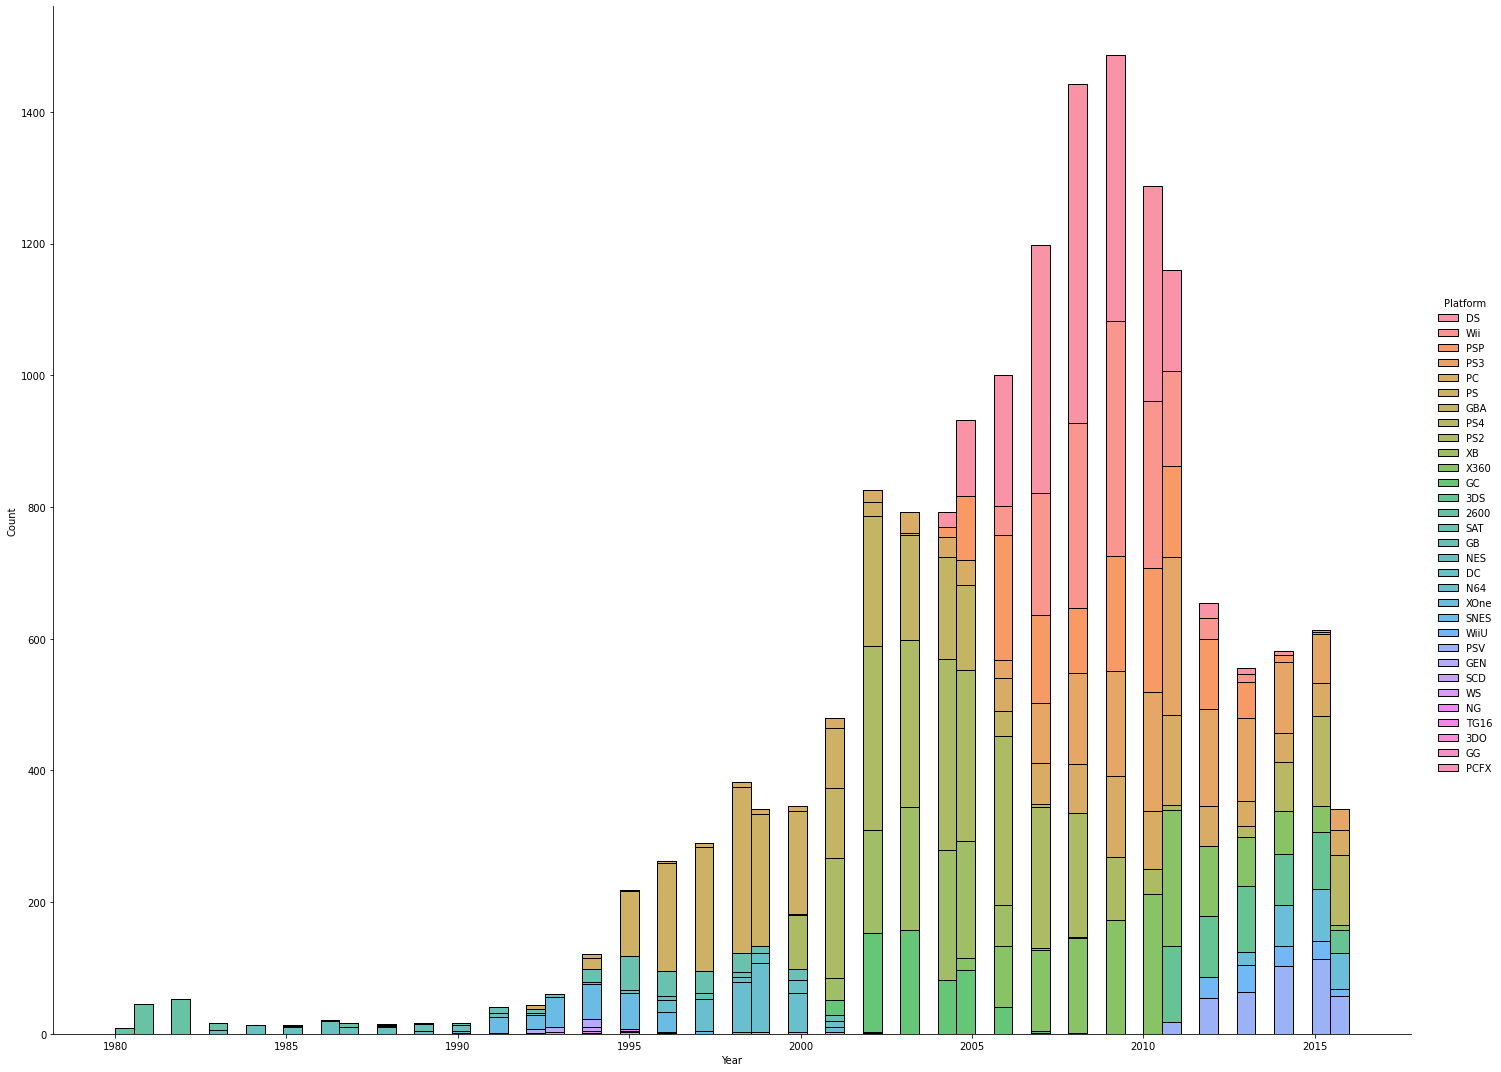

In [33]:
sns.displot(df1, x='Year', hue='Platform', multiple='stack', height=15, aspect=20/15);

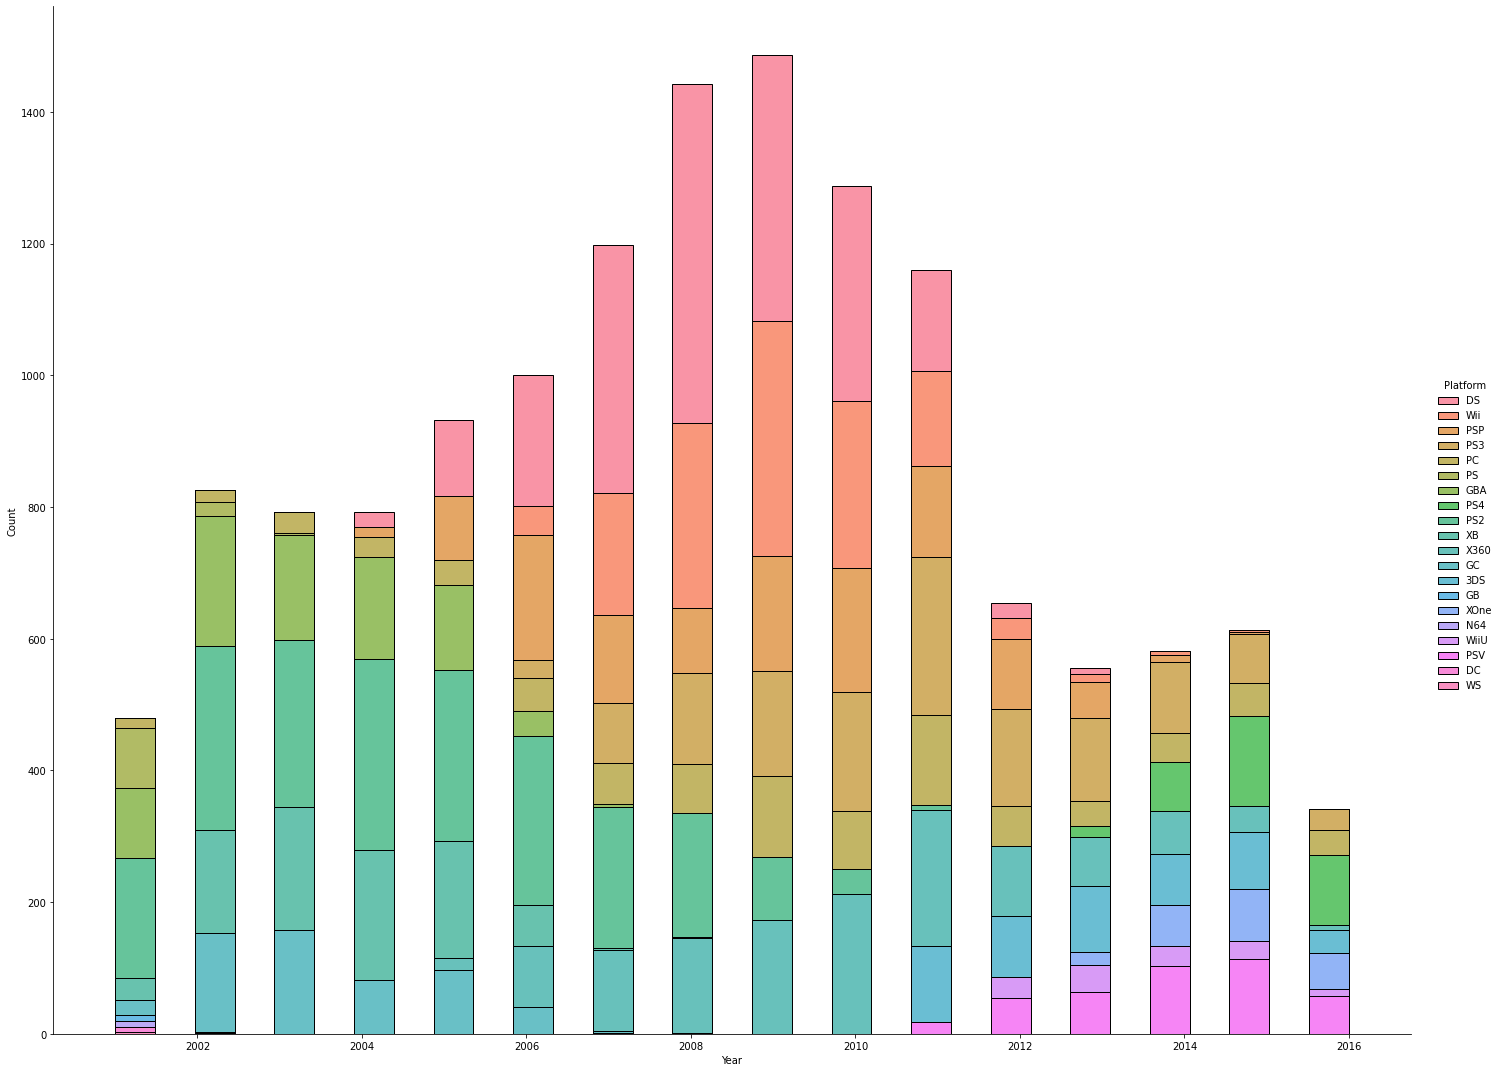

In [34]:
sns.displot(df2, x='Year', hue='Platform', multiple='stack', height=15, aspect=20/15);



> 2000년대 초반에는 PS2, XBOX 플랫폼을 지원하는 게임이 많이 출시됐습니다. 그러다 2005년을 기점으로 DS 플랫폼을 지원하는 게임이 크게 중가하고, 2006년에서 2011년까지 DS, PSP 지원 게임이 많이 출시됐습니다. 데이터 상 가장 최근인 2013년 이후로는 PS4 지원 게임의 비율이 매우 증가하면서 가장 많은 게임을 지원하고 있습니다.



##지역별 선호하는 게임은?



> 지역별로 좀 더 자세히 알아보겠습니다.





> 1980~2016년 사이에 북미, 유럽, 일본, 그외 지역에 따라 어떤 장르의 게임이 많이 소비됐는지 알아봅니다.



In [35]:
fig = px.pie(df, values='NA_Sales', names='Genre')
fig.show()

북미 지역에서는 Action, Sports, Shooter, Platform 장르 순으로 게임을 선호합니다.

In [36]:
fig = px.pie(df, values='EU_Sales', names='Genre')
fig.show()

유럽 지역에서는 Action, Sports, Shooter, Racing 장르 순으로 게임을 선호합니다.

In [37]:
fig = px.pie(df, values='JP_Sales', names='Genre')
fig.show()

일본 지역에서는 Role-Playing, Action, Sports, Platform 장르 순으로 게임을 선호합니다.

In [38]:
fig = px.pie(df, values='Other_Sales', names='Genre')
fig.show()

그외 지역에서는 Action, Sports, Shooter, Racing 장르 순으로 게임을 선호합니다.

👉 대체로 Action, Sports 장르가 모든 지역에서 많이 선호하는 것을 알 수 있습니다.



> 장르 이외에 어떤 게임 플랫폼을 많이 소비하는지 (2012~2016 기준) 알아봅니다.



In [39]:
df3 = df[(df['Year'] > 2011) & (df['Year'] < 2017)]

In [40]:
fig = px.pie(df3, values='NA_Sales', names='Platform')
fig.show()

북미 지역에서는 X360, PS3, PS4, XOne 플랫폼을 지원하는 게임을 많이 소비하고 있습니다.

In [41]:
fig = px.pie(df3, values='EU_Sales', names='Platform')
fig.show()

유럽 지역에서는 PS4, PS3, X360, XOne 플랫폼을 지원하는 게임을 많이 소비하고 있습니다.

In [42]:
fig = px.pie(df3, values='JP_Sales', names='Platform')
fig.show()

일본 지역에서는 3DS, PS3, PSV, PS4 플랫폼을 지원하는 게임을 많이 소비하고 있습니다.

In [43]:
fig = px.pie(df3, values='Other_Sales', names='Platform')
fig.show()

그외 지역에서는 PS3, PS4, X360, XOne 플랫폼을 지원하는 게임을 많이 소비하고 있습니다.

👉 대체로 PS3, PS4 플랫폼을 지원하는 게임을 모든 지역에서 소비하고 있음을 알 수 있습니다.

##매출이 높은 게임의 특성은?



> 매출액이 높았던 게임의 특성을 더 자세히 알아보겠습니다.



In [44]:
# sales sum
df['Global_Sales'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']



> 2012년도부터 북미, 유럽, 일본, 그외 지역의 매출액을 모두 합한 글로벌 매출액이 가장 높은 게임 20개를 살펴보겠습니다.



In [45]:
df2012 = df[(df['Year'] >= 2012)]
df_top_20 = df2012.sort_values(by=['Global_Sales'], ascending=False).head(20)
df_top_20

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
3483,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39
10913,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38
1971,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,Nintendo,5.17,4.05,4.34,0.79,14.35
9070,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,5.77,5.81,0.35,2.31,14.24
4240,Call of Duty: Black Ops II,PS3,2012,Shooter,Activision,4.99,5.88,0.65,2.52,14.04
6393,Call of Duty: Black Ops II,X360,2012,Shooter,Activision,8.25,4.30,0.07,1.12,13.74
2008,Grand Theft Auto V,PS4,2014,Action,Take-Two Interactive,3.80,5.81,0.36,2.02,11.99
4251,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,Nintendo,4.23,3.37,3.08,0.65,11.33
5604,Call of Duty: Ghosts,X360,2013,Shooter,Activision,6.72,2.63,0.04,0.82,10.21
10379,New Super Mario Bros. 2,3DS,2012,Platform,Nintendo,3.66,3.07,2.47,0.63,9.83


In [46]:
df_top_20.groupby(['Genre']).size().sort_values(ascending=False)

Genre
Shooter         8
Action          4
Role-Playing    3
Sports          1
Simulation      1
Platform        1
Misc            1
Fighting        1
dtype: int64

In [47]:
df_top_20.groupby(['Platform']).size().sort_values(ascending=False)

Platform
X360    5
PS4     5
3DS     5
PS3     4
DS      1
dtype: int64

👉 장르는 Shooter, Action이, 플랫폼은 X360, PS4, 3DS가 가장 많습니다.

👉 Grand Theft Auto V 게임은 꾸준히 다양한 플랫폼을 지원하며 높은 매출액을 보였습니다. 또한 Pokemon 시리즈, Call of Duty 시리즈, FIFA 시리즈가 상위권에 다수 랭크된 것을 볼 수 있습니다.

👉 게임의 장르 및 플랫폼도 게이머에게 중요한 요소이지만 **게임의 콘텐츠** 또한 매출에 영향을 많이 주는 것을 알 수 있습니다.

##어느 지역을 타겟으로 제품을 만드는 것이 좋을까?



> 북미, 유럽, 일본, 그외 지역의 게임 시장 크기를 비교해봅시다.





> 먼저 지역별 누적 매출액을 비교해봅시다.



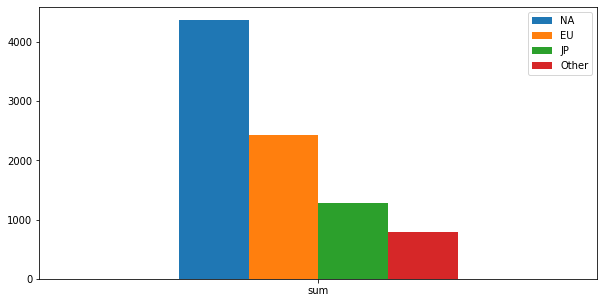

In [48]:
whole_na_sales = df['NA_Sales'].sum()
whole_eu_sales = df['EU_Sales'].sum()
whole_jp_sales = df['JP_Sales'].sum()
whole_other_sales = df['Other_Sales'].sum()
whole_sales = [[whole_na_sales, whole_eu_sales, whole_jp_sales, whole_other_sales]]
df_whole_sales = pd.DataFrame(data=whole_sales, index=['sum'], columns=['NA', 'EU', 'JP', 'Other'])
df_whole_sales.plot(kind='bar', figsize=(10, 5), rot=0);



> 유의미한 차이인지 검정해봅시다.



In [49]:
# 지역에 대해서 one-sample chi-square test
print(chisquare(np.array(whole_sales[0])))

Power_divergenceResult(statistic=3413.0633980289645, pvalue=0.0)


👉 p-value가 0.0으로, 신뢰도 95% 기준 alpha 값 0.05보다 작습니다. 따라서 지역별로 누적 매출액은 균등한 분포를 나타낸다는 귀무가설을 기각하고, 균등한 누적 매출액을 나타내지 않는다는 대안가설을 채택합니다.

👉 **즉, 지역별로 유의미한 누적 매출액의 차이가 있습니다.**



> 평균 매출액도 비교해봅시다.



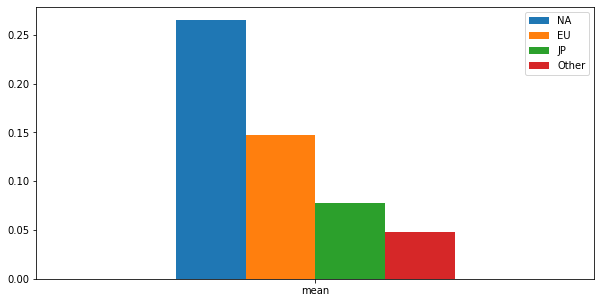

In [50]:
mean_na_sales = df['NA_Sales'].mean()
mean_eu_sales = df['EU_Sales'].mean()
mean_jp_sales = df['JP_Sales'].mean()
mean_other_sales = df['Other_Sales'].mean()
mean_sales = [[mean_na_sales, mean_eu_sales, mean_jp_sales, mean_other_sales]]
df_mean_sales = pd.DataFrame(data=mean_sales, index=['mean'], columns=['NA', 'EU', 'JP', 'Other'])
df_mean_sales.plot(kind='bar', figsize=(10, 5), rot=0);



> 유의미한 차이인지 검정해봅시다.



In [51]:
from scipy.stats import f_oneway
f_oneway(df['NA_Sales'], df['EU_Sales'], df['JP_Sales'], df['Other_Sales'])

F_onewayResult(statistic=578.5329410266196, pvalue=0.0)

👉 p-value가 0.0으로, 신뢰도 95% 기준 alpha 값 0.05보다 작습니다. 따라서 지역별로 평균 매출액은 차이가 없다는 귀무가설을 기각하고, 지역별 평균 매출액의 차이가 있다는 대안가설을 채택합니다.

👉 **즉, 지역별로 유의미한 평균 매출액의 차이가 있습니다.**



> 게임이 많이 소비되는 북미와 유럽 시장을 겨냥해서 제품을 설계하는 방안을 고려해볼만 합니다.



##Our Next Game is...

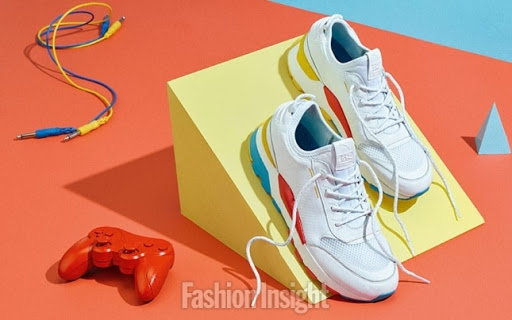

📌 *세계적으로 코로나19 집단 감염을 막기 위한 고강도 사회적 거리두기가 실시되면서 피트니스 산업에서도 사람 간 직접적인 접촉을 피할 수 있는 ‘언택트(untact)’ 소비 확산*

📌 *디지털 피트니스 시장 가능성과 잠재력에 주목하며 스마트 헬스 기구･콘텐츠 개발, 서비스 차별화 등 행보 활발*

### **Target :** NA, EU → Global

### **Game Genre :** Sports + Action

### **Key Value :** Contents Marketing

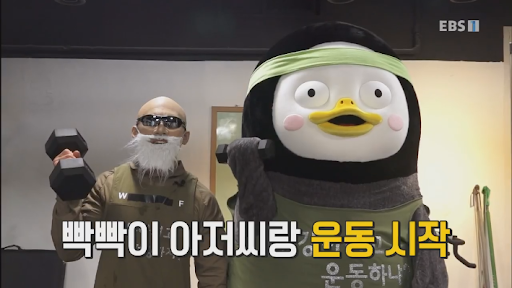